In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import ipynb.fs.full.preProcessing as preProcessing
# from ipynb.fs.full.eda_new import population_data as _population_data
from ipynb.fs.full.eda_new import population_data

In [194]:
df = pd.read_csv('./final.csv')

cleaned_egm = preProcessing.cleanedEgm
cleaned_offences = preProcessing.cleanedOffences
cleaned_housing_prices = preProcessing.cleanedHousingPrice
cleaned_communities = preProcessing.cleanedCommunities

# Restructure dataframe
cleaned_housing_prices_melted = pd.melt(cleaned_housing_prices.reset_index(), id_vars=['LGA'], var_name='Year', value_name='house_price')
cleaned_housing_prices_melted.head()

# Convert year to int and increment by 1 to lag the year
cleaned_housing_prices_melted['Year'] = cleaned_housing_prices_melted['Year'].astype(int) + 1

# Merge with housing prices data
merged = pd.merge(left=cleaned_communities, right=cleaned_housing_prices_melted, on="LGA")

# Merge with population data
merged = pd.merge(left=merged, right=population_data, left_on=["LGA", 'Year'], right_on=["lga", 'year'], how='left')

# print(merged['population'].shift(-1))
merged['last_year_population'] = merged['population'].shift(1)
merged = merged.dropna()

features = [
    'Location_x',
    'Location_y',
    'last_year_population',
    'Residential (km^2)',
    'Number of Households',
    'Occupied private dwellings',
    'Equivalent household income <$600/week',
    'Personal income <$400/week, persons',
    'Number of families',
    'Aged 75+ and lives alone, persons',
    'house_price',
    'Year'
]

# There are some missing values in the population data
# Turns out that the missing values all belong to the year 2024, which does not exist in offences dataset, but is in housing prices dataset
print(merged[merged['lga'].isnull()]['Year'].unique())

# Drop rows with year 2013, or use inner join above
merged = merged[merged['Year'] != 2024]

print(merged.shape)

print(merged[['Year', 'last_year_population', 'population']])

print(list(merged.columns))  

[]
(504, 110)
     Year  last_year_population     population
1    2015          12355.151066   12429.148769
2    2016          12429.148769   12578.003120
3    2017          12578.003120   12686.879978
4    2018          12686.879978   12821.932369
5    2019          12821.932369   12904.102146
..    ...                   ...            ...
610  2019         157818.811310  158744.984087
611  2020         158744.984087  158876.131396
612  2021         158876.131396  157420.048819
613  2022         157420.048819  157386.299515
614  2023         157386.299515  158832.592725

[504 rows x 3 columns]
['LGA', 'Travel time to GPO (minutes)', 'Area (km^2)', 'ARIA+ (min)', 'ARIA+ (max)', 'ARIA+ (avg)', 'Commercial (km^2)', 'Industrial (km^2)', 'Residential (km^2)', 'Rural (km^2)', 'Other (km^2)', '2012 ERP age 0-4, persons', '2012 ERP age 5-9, persons', '2012 ERP age 10-14, persons', '2012 ERP age 15-19, persons', '2012 ERP age 20-24, persons', '2012 ERP age 25-44, persons', '2012 ERP age 45-64,

# The two models below are trained independently for each LGA, might not be accurate?

In [195]:
# Linear Regression using single test-train split for each LGA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model_data = merged.groupby('LGA')

model = LinearRegression()

mse_values = []
rmse_values = []

for lga, group in model_data:
    X = group[features]
    y = group['population'] # From population_data dataframe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randint(1, 10000000))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    # print("Predicted Population:", y_pred)

    mse = mean_squared_error(y_test, y_pred)
    # print("Mean Squared Error (MSE):", mse)
    mse_values.append(mse)

    rmse = np.sqrt(mse)
    # print("Root Mean Squared Error (RMSE):", rmse)
    rmse_values.append(rmse)


print("Mean Squared Error (MSE):", np.mean(mse_values))
print("Root Mean Squared Error (RMSE):", np.mean(rmse_values))

rmse_percentage = np.mean(rmse_values) / np.mean(merged['population']) * 100
print(rmse_percentage, "%")

Mean Squared Error (MSE): 11219734.957372325
Root Mean Squared Error (RMSE): 1874.7372408614272
1.723927385561757 %


In [196]:
# Linear Regression using KFold for each LGA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

model_data = merged.groupby('LGA')

model = LinearRegression()

mse_values = []
rmse_values = []

kf = KFold(n_splits=9, shuffle=True, random_state=randint(1, 10000000))

for lga, group in model_data:
    X = group[features]
    y = group['population'] # From population_data dataframe

    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        # print("Predicted Population:", y_pred)

        mse = mean_squared_error(y_test, y_pred)
        # print("Mean Squared Error (MSE):", mse)
        mse_values.append(mse)

        rmse = np.sqrt(mse)
        # print("Root Mean Squared Error (RMSE):", rmse)
        rmse_values.append(rmse)


print("Mean Squared Error (MSE):", np.mean(mse_values))
print("Root Mean Squared Error (RMSE):", np.mean(rmse_values))

rmse_percentage = np.mean(rmse_values) / np.mean(merged['population']) * 100
print(rmse_percentage, "%")

Mean Squared Error (MSE): 6588457.137114985
Root Mean Squared Error (RMSE): 1349.5644262733067
1.2410011506270937 %


# Train on across all LGA (using one-hot encoding)

In [197]:
# Linear Regression using KFold for each LGA

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

model_data = merged.copy()

# One-hot encode LGA column
unique_lga_names = model_data['LGA'].apply(lambda x: 'LGA_' + x).unique()
model_data_encoded = pd.get_dummies(model_data, columns=['LGA'])

# Combine one-hot encoded LGA columns with other features
features_new = [
    *features,
    *unique_lga_names
]

model = LinearRegression()

mse_values = []
rmse_values = []
results = {
    'prediction': [],
    'actual': [],
}

kf = KFold(n_splits=10, shuffle=True, random_state=randint(1, 10000000))

# for lga, group in model_data:
X = model_data_encoded[features_new]
y = model_data_encoded['population'] # From population_data dataframe

for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    # print("Predicted Population:", y_pred)
    results['prediction'].append(y_pred[0])
    results['actual'].append(y_test.iloc[0])

    mse = mean_squared_error(y_test, y_pred)
    # print("Mean Squared Error (MSE):", mse)
    mse_values.append(mse)

    rmse = np.sqrt(mse)
    # print("Root Mean Squared Error (RMSE):", rmse)
    rmse_values.append(rmse)


print("Mean Squared Error (MSE):", np.mean(mse_values))
print("Root Mean Squared Error (RMSE):", np.mean(rmse_values))

rmse_percentage = np.mean(rmse_values) / np.mean(merged['population']) * 100
print(rmse_percentage, "%")

results = pd.DataFrame(results)

Mean Squared Error (MSE): 5258576.840792875
Root Mean Squared Error (RMSE): 2166.6371573584065
1.9923459398659908 %


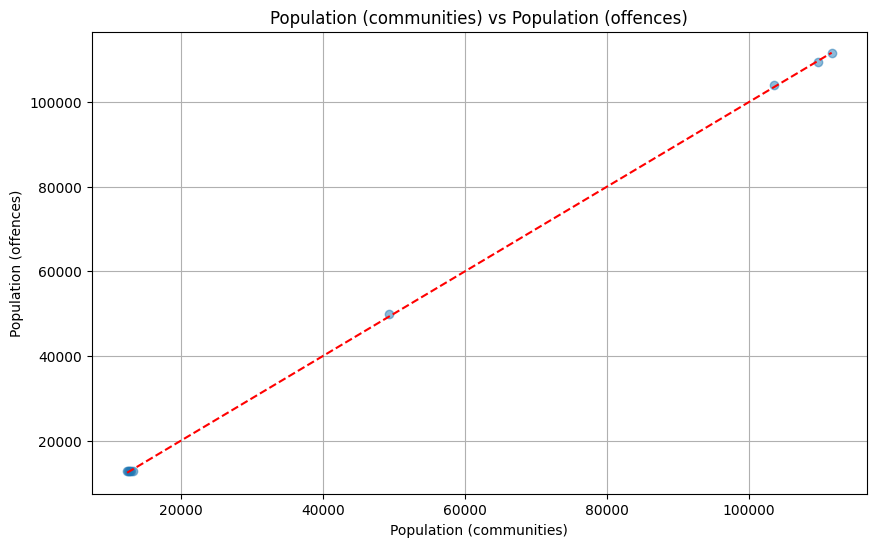

In [198]:
plt.figure(figsize=(10, 6))
plt.scatter(results['actual'], results['prediction'], alpha=0.5)
plt.plot(
    [results['actual'].min(), results['actual'].max()],
    [results['actual'].min(), results['actual'].max()],
    color='red', 
    linestyle='--'
)
plt.title('Population (communities) vs Population (offences)')
plt.xlabel('Population (communities)')
plt.ylabel('Population (offences)')
plt.grid(True)
plt.show()

In [199]:
results[['prediction', 'actual']].corr()
# print(results)

,prediction,actual
prediction,1.000000,0.999977
actual,0.999977,1.000000


# Predict Population

Index(['Location_x', 'Location_y', 'last_year_population', 'Year',
       'LGA_alpine', 'LGA_ballarat', 'LGA_banyule', 'LGA_basscoast',
       'LGA_bawbaw', 'LGA_bayside', 'LGA_benalla', 'LGA_boroondara',
       'LGA_brimbank', 'LGA_campaspe', 'LGA_cardinia', 'LGA_casey',
       'LGA_centralgoldfields', 'LGA_colacotway', 'LGA_darebin',
       'LGA_eastgippsland', 'LGA_frankston', 'LGA_gleneira', 'LGA_glenelg',
       'LGA_greaterbendigo', 'LGA_greaterdandenong', 'LGA_greatergeelong',
       'LGA_greatershepparton', 'LGA_hobsonsbay', 'LGA_horsham', 'LGA_hume',
       'LGA_kingston', 'LGA_knox', 'LGA_latrobe', 'LGA_macedonranges',
       'LGA_manningham', 'LGA_maribyrnong', 'LGA_maroondah', 'LGA_melbourne',
       'LGA_melton', 'LGA_merribek', 'LGA_mildura', 'LGA_mitchell',
       'LGA_monash', 'LGA_mooneevalley', 'LGA_moorabool',
       'LGA_morningtonpeninsula', 'LGA_northerngrampians', 'LGA_portphillip',
       'LGA_southgippsland', 'LGA_stonnington', 'LGA_surfcoast',
       'LGA_swan

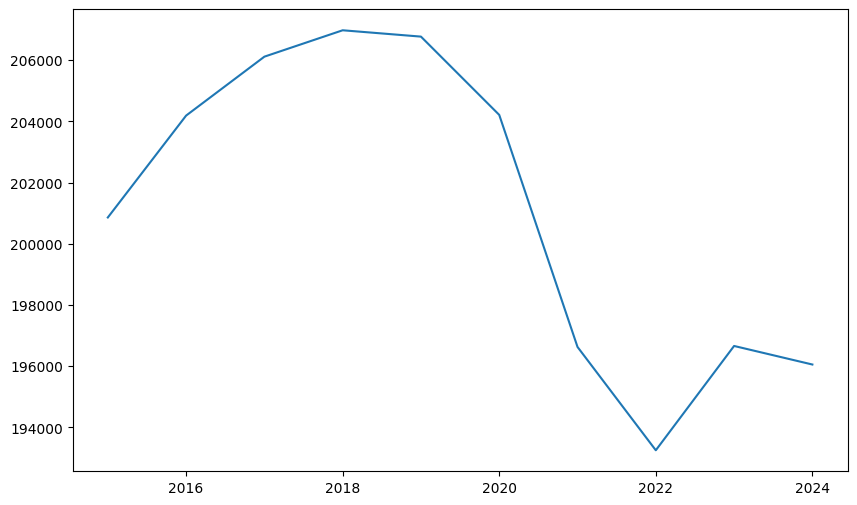

In [200]:
predict_data = model_data_encoded[features_new]

print(predict_data.columns)

location = 'LGA_brimbank'
most_recent_year = 2023
predict_year = 2024

p_data = model_data_encoded[(model_data_encoded[location] == True) & (model_data_encoded['Year'] == most_recent_year)]
p_data = p_data.copy()
p_data['last_year_population'] = p_data['population']
p_data['year'] = predict_year

# Only keep feature columns
p_data = p_data[features_new]

y_pred = model.predict(p_data)
print(f'{predict_year} predicted population:', y_pred[0])
print(f'{most_recent_year} population:', p_data['last_year_population'].iloc[0])

historic_rows = model_data_encoded[model_data_encoded[location] == True][['Year', 'population']]
# historic_populations = pd.merge(historic_populations, 
predicted_row = pd.DataFrame({'Year': predict_year, 'population': y_pred[0]}, index=[0])
# historic_populations.append({'Year': predict_year, 'population': y_pred[0]}, ignore_index=True)
# historic_populations.append
population_rows = pd.concat([historic_rows, predicted_row], ignore_index=True)
# population_rows

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(population_rows['Year'], population_rows['population'])
# y_pred

2024 predicted population: 12928.354558223073
2023 population: 13234.05665910192
2024 predicted population: 119220.68266709268
2023 population: 117955.63700071488
2024 predicted population: 128766.0735590111
2023 population: 129021.94587855443
2024 predicted population: 43425.034712501714
2023 population: 42705.91123756156
2024 predicted population: 61531.02525526266
2023 population: 60658.39179708581
2024 predicted population: 103285.07593345398
2023 population: 103375.13832534119
2024 predicted population: 14238.45572706309
2023 population: 14492.753623188406
2024 predicted population: 174063.50877199753
2023 population: 174228.83589096306
2024 predicted population: 196056.93241939528
2023 population: 196663.05125424042
2024 predicted population: 38407.409974523296
2023 population: 38653.19467422989
2024 predicted population: 130299.00720375396
2023 population: 127210.25127067076
2024 predicted population: 400568.3153041181
2023 population: 391649.53450667736
2024 predicted populatio

/var/folders/19/534nl8853rg0sycn60dtsltr0000gn/T/ipykernel_39447/2258626695.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


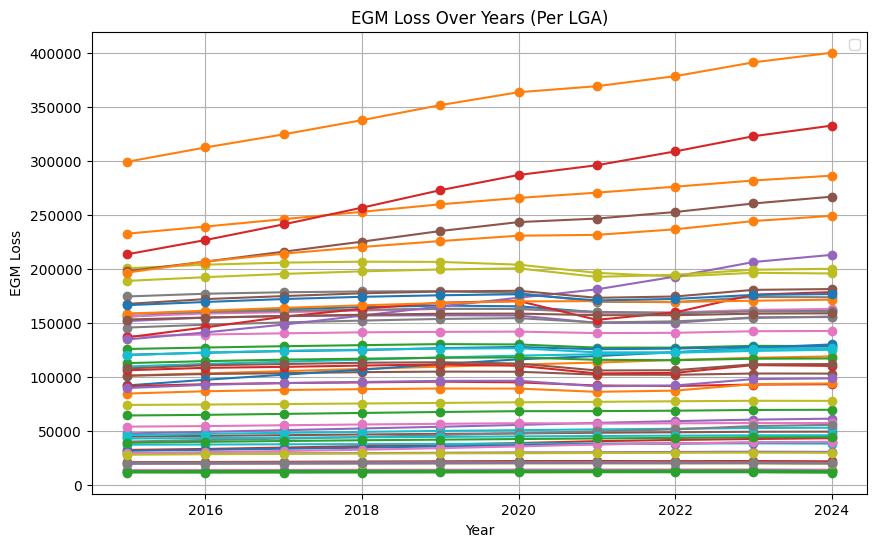

In [201]:
predict_data = model_data_encoded[features_new]
fig, ax = plt.subplots(figsize=(10, 6))

# print(predict_data.columns)
for location in predict_data.columns:
    # print(location)
    if 'LGA_' not in location:
        continue
    # print(col)

    # location = 'LGA_brimbank'
    most_recent_year = 2023
    predict_year = 2024

    p_data = model_data_encoded[(model_data_encoded[location] == True) & (model_data_encoded['Year'] == most_recent_year)]
    p_data = p_data.copy()
    p_data['last_year_population'] = p_data['population']
    p_data['year'] = predict_year

    # Only keep feature columns
    p_data = p_data[features_new]

    y_pred = model.predict(p_data)
    print(f'{predict_year} predicted population:', y_pred[0])
    print(f'{most_recent_year} population:', p_data['last_year_population'].iloc[0])

    historic_rows = model_data_encoded[model_data_encoded[location] == True][['Year', 'population']]
    predicted_row = pd.DataFrame({'Year': predict_year, 'population': y_pred[0]}, index=[0])
    population_rows = pd.concat([historic_rows, predicted_row], ignore_index=True)

    ax.plot(population_rows['Year'], population_rows['population'], marker='o')

ax.set_title('EGM Loss Over Years (Per LGA)')
ax.set_xlabel('Year')
ax.set_ylabel('EGM Loss')
ax.legend()
ax.grid(True)
plt.show()
# y_pred